# Bayesian inference on quantum measurements

This notebook provides a basic sumamry of the Bayesian analysis and experiments in [Convy and Whaley (2022)](https://quantum-journal.org/papers/q-2022-04-04-680/) and [Convy and Liao et al. (2022)](https://iopscience.iop.org/article/10.1088/1367-2630/ac66f9). Both papers utilize Bayesian models to perform quantum error detection/correction, which will be our focus here.

## A brief introduction to quantum error correction

When using a quantum computer, we are interested in the behavior of objects known as _qubits_. A qubit is similar to the classical bit used in standard computers, except that it take on states that are in-between the usual 0 and 1 binary values. These intermediate configurations are known as _superpositions_, and are what allow quantum computers to carry out certain tasks much more efficiently than standard computers.

One of the disadvantages of quantum computers is that they are very susceptibile to errors. These errors perturb the state of the qubits, and will ultimately corrupt the output of the algorithm if not corrected. Fortunately, it is possible to monitor the state of the qubits in real time during a calculation and detect when an error occurs. An operation can then be performed on the affected qubit to undo the error and bring the qubit back into its correct state.

The qubits are monitored by performing quantum measurements, which will generate time-series data that can be analyzed to check for errors. The form of these measurements will change depending on the number of qubits and the type of errors that are expected, but for simplicity we will focus on a three-qubit system that is perturbed by bit-flip errors. Under normal operations, each qubit should be in the same state as the other qubits, but a bit-flip error on one of the qubits will break this symmetry. To determine which qubit has been flipped, we can perform a _parity measurement_ on two different pairs of qubits, which gives a value of -1 if the two qubits are in the same state and +1 if they are in different states. If at least one measurement returns a value of +1, then we know that an error has occured and can figure out which qubit was flipped.

The process described above is very straightforward if we can know the exact values of the parity measurements, but unfortunately this often not possible. Instead, we end up with a signal whose mean will be centered on +1 or -1, but which will also have a large amount of Gaussian noise on top of it. To extract out the parity measurement, we must apply some kind of filtering algorithm to the signal, which is where Bayesian inference can be very useful.

## The measurement data

Before describing the Bayesian model, we will first take a closer look at the measurement data itself. Since we are interested in training an algorithm to detect bit-flip errors, we will want to look at measurements from qubits that have been deliberately flipped in a consistent and controlled manner. The following code loads a set of sample measurement data and plots one of the time series:

The data has 192 measurements in the time series for each of the two qubit pairs.


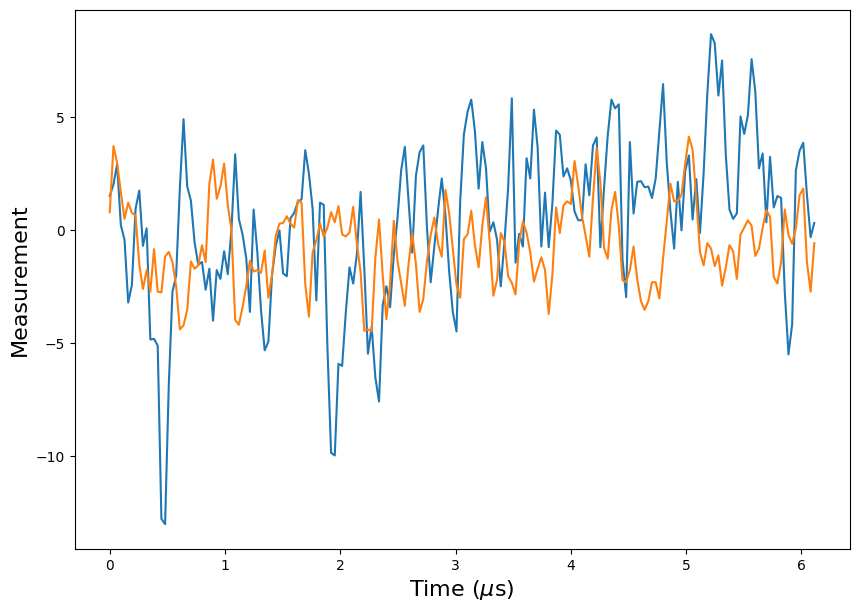

In [2]:
import matplotlib.pyplot as plt
import numpy as np

data = np.load("src/data/measurements.npz")
measurements = data["measurements"][0, 1, :, 0] # Index 1 marks the qubit state, Index 2 marks the flipped qubit
print(f"The data has {measurements.shape[1]} measurements in the time series for each of the two qubit pairs.")
plt.plot(data["times"], measurements.T)
plt.xlabel(r"Time ($\mu$s)", fontsize = 16)
plt.ylabel("Measurement", fontsize = 16)
plt.gcf().set_size_inches(10, 7)
plt.show()

Although it is difficult to tell from this plot, both of the parity measurements (the parity of the first and second qubit is shown in blue, while the parity of the second and third qubits is shown in orange) are centered on -1 until the 3 $\mu$s mark. Then an error occurs on the first qubit, which causes the mean of the blue line to shift down to +1. It is clear from the plot that there is a significant amount of noise in the measurements, with noticeable autocorrelation between neighboring values. 

Given the large variance in the measurements, the changes induced by the bit flips are easiest to see by plotting the measurement means.

<img src="src/data/means.png"  width="850">

Each row of plots corresponds to a different starting configuration of the qubits, with each qubit either in the 0 or 1 state. The different columns correspond to different bit flips, with the first column containing no bit flips and columns 2, 3, and 4 corresponding to flips of qubits 1, 2, and 3 respectively. The figure as a whole shows several interesting behaviors, such as a clear oscillation pattern that occurs after certain flips. We can also see that the means do not exactly align at +1 and -1, but instead drift somewhat over time. These imperfections are something that will need to be dealt with by the filtering algorithm.

## The Bayesian filter

Our goal in quantum error correction is to determine what error, if any, has perturbed the state of the qubits in our quantum computer. Given the measurement signals plotted in the previous section, the detection of an error is equivalent to detecting when the mean of the measurement signal switches from -1 to +1. Assuming that the errors are uncorrelated, we can describe the system of qubits and measurement signal using a hidden Markov model. The qubit states represent a hidden Markovian variable, with a probability of transition depending only on the current state. Since the measurement signal follows a Gaussian distribution whose mean is determined by the qubit states, we can use observations of the signal to make inferences about the hidden Markov variable. The following code shows the basic features of the hidden Markov model:

In [3]:
import torch

class Bayesian():

    # This class represenrs the Bayesian classifier designed to handle
    # the autocorrelations present in imperfect measurement data.

    def __init__(self, depth):

        # The depth attribute determines how many prior syndrome measurements to
        # condition on when calculating the Gaussian likelihood of a new syndrome
        # measurement. For depth > 0, this allows the model to leverage any
        # autocorrelation that may be present in the data.

        self.depth = depth

        # This is simply a list of the other attributes that will be used.

        self.transition_matrix = None
        self.gauss_means = None
        self.gauss_precs = None
        self.prior = None
        self.prev_synd = None

    def classify(self, measurements):

        # This method returns the posterior probability, with shape (num_runs, 8),
        # of each label given a batch of measurments with shape (num_runs, 2). The
        # internal state of the classifier is also updated appropriately, with the
        # prior being updated to the posterior and the previous syndromes being
        # updated to include the new measurements.

        m_1_batch = torch.cat(
            [self.prev_synd[:, 0:1], measurements[None, 0:1]], dim=1)
        m_2_batch = torch.cat(
            [self.prev_synd[:, 1:2], measurements[None, 1:2]], dim=1)
        likelihood = self.get_gaussian_outputs(m_1_batch, m_2_batch)
        unnorm_probs = torch.einsum(
            "al,lr->ar", self.prior.float(), self.transition_matrix.float()) * likelihood
        posteriors = unnorm_probs / \
            torch.sum(unnorm_probs, dim=1, keepdim=True)
        self.prior = posteriors
        if self.depth:
            self.prev_synd = torch.cat(
                [self.prev_synd[1:, :], measurements[None, :]])
        return posteriors[0]

    def get_gaussian_outputs(self, m_1_batch, m_2_batch):

        # This method calculates the Gaussian likelihoods for the syndrome pair in
        # the most recent step, conditioned on a number of prior measurements determined
        # by the depth attribute. This means that the m_1_batch and m_2_batch must both
        # have shapes of (num_runs, depth + 1).

        (num_runs, num_steps) = m_1_batch.shape
        joint_batch = torch.cat([m_1_batch, m_2_batch], dim=1)
        marg_batch = torch.cat([m_1_batch[:, :-1], m_2_batch[:, :-1]], dim=1)

        joint_centered = joint_batch.reshape(
            [num_runs, 1, 2*(self.depth + 1)]) - self.joint_means.reshape([1, 8, 2*(self.depth + 1)])
        joint_expon = -0.5*torch.einsum("ali,lij,alj->al", joint_centered.float(
        ), self.joint_precs.float(), joint_centered.float())
        joint_output = joint_expon + 0.5*torch.slogdet(self.joint_precs)[1]

        if self.depth > 0:  # The marginal distribution only exists if depth > 0
            marg_batch = torch.cat(
                [m_1_batch[:, :-1], m_2_batch[:, :-1]], dim=1)
            marg_centered = marg_batch.reshape(
                [num_runs, 1, 2*self.depth]) - self.marg_means.reshape([1, 8, 2*self.depth])
            marg_expon = -0.5*torch.einsum("ali,lij,alj->al", marg_centered.float(
            ), self.marg_precs.float(), marg_centered.float())
            marg_output = marg_expon + 0.5*torch.slogdet(self.marg_precs)[1]
            log_output = joint_output - marg_output
        else:
            log_output = joint_output
        outputs = torch.exp(log_output)  # Only exponentiate at the end
        return outputs

The main method of interest here is `classify`, which takes as input two parity measurements (one for each pair of qubits) and returns a set of posterior probabilities for each qubit configuration (i.e. the state of the hidden Markov variable). The model starts by transforming its prior distribution, which are the probabilities generated by the previous call to `classify` (or the initial state of the qubits) using the bit-flip transition matrix, and then updates them based on the measurement data. Since the measurement are Gaussian distributed, we can easily compute the likelihood associated with each qubit state by setting the means to +1 or -1, which is done in the `get_gaussian_outputs` method. In order to take into account any autocorrelation between sequential samples, we can store the previous measurement values and use them as input to the Gaussian likelihood.

In the code block above, the transition matrix and Gaussian parameter are left uninitialized. To get values for them, we can fit to a set of measurement data like that shown in the previous section. For each qubit state, the means of the measurement values can be computed and stored in `self.gauss_means`, while variance and covariance values are stored in `self.gauss_precs`. The transition matrix cannot be fit using data with artificial errors, but its elements can be computed by assuming some plausible error rate for the quantum computer based on its hardware.

To evaluate a trained model, we can simulate measurement data and then test how well the model is able to predict the state of the (simulated) qubits. An example test is shown in the following code:

In [ ]:
import torch

from src import tools, real_data

print("Generating data...")
(train_data, train_labels) = tools.Real_Simulated(error_rate_sec = 0.01*1e6).generate_data(30000, 60)
(test_data, test_labels) = tools.Real_Simulated(error_rate_sec = 0.01*1e6).generate_data(30000, 60)

model = real_data.Bayesian(0)
model.train(train_data, train_labels)

m_1 = test_data[:, :, 0]
m_2 = test_data[:, :, 1]
(num_runs, num_steps) = m_1.shape
outputs = torch.zeros([num_runs, 0])
model.prior = torch.zeros([num_runs, 8])
model.prior[torch.arange(num_runs), test_labels[:, 0].type(torch.long)] = 1
num_correct = torch.zeros([num_runs])
print("Testing...")
for step in range(num_steps):

    # For each step, the new prior is calculated by contracting the previous
    # prior with the transition matrix, then scaling by the measurement 
    # probabilities.

    m_1_slice = m_1[:, step:step + 1]
    m_2_slice = m_2[:, step:step + 1]
    sample_probs = model.get_gaussian_outputs(m_1_slice, m_2_slice)
    unnorm_probs = torch.einsum("al,lr->ar", model.prior.float(), model.transition_matrix.float()) * sample_probs
    model.prior = unnorm_probs / torch.sum(unnorm_probs, dim = 1, keepdim = True)
    predictions = torch.argmax(model.prior, dim = 1)
    true_states = test_labels[:, step]
    fidelity = (predictions == true_states)
    num_correct = num_correct + fidelity
    outputs = torch.cat([outputs, predictions[:, None]], dim = 1)
    print("\rStep {}/{}".format(step, num_steps), end = "")

acc = num_correct * 100 / num_steps
print("\nAcc: {:.2f}%".format(torch.mean(acc)))

The final accuracy value reports how often the model correctly predicted the state of the system. Due to the irreducible noise in the measurement value, an accuracy of 100% will be virtually impossible for any large sample size. Indeed, the performance of this model is effectively optimal on the simulated data, since we use a Gaussian distribution to sample the measurement values and assume that the qubits states follow Markovian dynamics.